<h1>House Prices Project
    
Part 1: Exploratory Data Analysis and Feature Engineering</h1>

In this notebook, I present my data preparation and my analysis of the House Prices Project dataset.

Here you'll find feature engineering techniques and some visualizations that help us have a good idea of how this dataset is structured.

<h2>Loading libraries and datasets</h2>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import zipfile

from scipy.stats import pearsonr
from scipy.stats import mode

%matplotlib inline
sns.set(style='white', context='notebook', palette='deep')
plt.rcParams["figure.figsize"] = (15,7) # plot size

C:\Users\Paulo\.conda\envs\Kaggle\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
archive = zipfile.ZipFile('house-prices-advanced-regression-techniques.zip', 'r')
train = pd.read_csv(archive.open('train.csv'))
test = pd.read_csv(archive.open('test.csv'))

<h2>Checking the datasets</h2>

First things first. Let's see the datasets dimensions.

In [3]:
print('Train shape: ' + str(train.shape) + '.')
print('Test shape: ' + str(test.shape) + '.')

Train shape: (1460, 81).
Test shape: (1459, 80).


Since we already have more than 80 columns in the training set, I'll adjust the display to show up to 100 rows and columns. This can help us better visualize some data that will be generated.

In [4]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

Let's check for missing values.

In [5]:
print('Missing values in the train set: ' + str(train.isnull().sum().sum()) + '.')
print('Missing values in the test set: ' + str(test.isnull().sum().sum()) + '.')

Missing values in the train set: 6965.
Missing values in the test set: 7000.


It will be necessary to work on this missing values. Since there are several missing values in the train and test sets, is more efficient to join both datasets and work on the missing values than to do it separately.

In [6]:
train['dataset'] = 'train'   # identify this as the train dataset
test['dataset'] = 'test'     # identify this as the train dataset
dataset = train.append(test, sort = False, ignore_index = True) # merge both datasets
del train, test              # free some memory.

In [7]:
dataset.shape

(2919, 82)

In [8]:
dataset.dataset.value_counts()

train    1460
test     1459
Name: dataset, dtype: int64

Checking all the columns in the dataset and getting some statistics.

In [9]:
dataset.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [10]:
stats = dataset.describe().T
for i in range(len(dataset.columns)):
    stats.loc[dataset.columns[i], 'mode'], stats.loc[dataset.columns[i], 'mode_count'] = mode(dataset[dataset.columns[i]])
    stats.loc[dataset.columns[i], 'unique_values'] = dataset[dataset.columns[i]].value_counts().size
    stats.loc[dataset.columns[i], 'NaN'] = dataset[dataset.columns[i]].isnull().sum()
    if np.isnan(stats.loc[dataset.columns[i], 'count']): 
        stats.loc[dataset.columns[i], 'count'] = dataset.shape[0] - stats.loc[dataset.columns[i], 'NaN']
stats = stats[['count', 'NaN', 'unique_values', 'mode', 'mode_count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
stats.index.name = 'variable'
stats.reset_index(inplace = True)
stats

,variable,count,NaN,unique_values,mode,mode_count,mean,std,min,25%,50%,75%,max
0,Id,2919.0,0.0,2919.0,1,1.0,1460.000000,842.787043,1.0,730.5,1460.0,2189.5,2919.0
1,MSSubClass,2919.0,0.0,16.0,20,1079.0,57.137718,42.517628,20.0,20.0,50.0,70.0,190.0
2,LotFrontage,2433.0,486.0,128.0,60,276.0,69.305795,23.344905,21.0,59.0,68.0,80.0,313.0
3,LotArea,2919.0,0.0,1951.0,9600,44.0,10168.114080,7886.996359,1300.0,7478.0,9453.0,11570.0,215245.0
4,OverallQual,2919.0,0.0,10.0,5,825.0,6.089072,1.409947,1.0,5.0,6.0,7.0,10.0
5,OverallCond,2919.0,0.0,9.0,5,1645.0,5.564577,1.113131,1.0,5.0,5.0,6.0,9.0
6,YearBuilt,2919.0,0.0,118.0,2005,142.0,1971.312778,30.291442,1872.0,1953.5,1973.0,2001.0,2010.0
7,YearRemodAdd,2919.0,0.0,61.0,1950,361.0,1984.264474,20.894344,1950.0,1965.0,1993.0,2004.0,2010.0
8,MasVnrArea,2896.0,23.0,444.0,0,1738.0,102.201312,179.334253,0.0,0.0,0.0,164.0,1600.0
9,BsmtFinSF1,2918.0,1.0,991.0,0,929.0,441.423235,455.610826,0.0,0.0,368.5,733.0,5644.0


<h2>Feature Engineering</h2>

<h3>Dealing with NaN Values</h3>

Let's treat all these missing data. First of all, lets check how many observations in each variable are missing values.

,variable,NaN
76,PoolQC,2909.0
78,MiscFeature,2814.0
40,Alley,2721.0
77,Fence,2348.0
37,SalePrice,1459.0
70,FireplaceQu,1420.0
2,LotFrontage,486.0
25,GarageYrBlt,159.0
72,GarageFinish,159.0
73,GarageQual,159.0


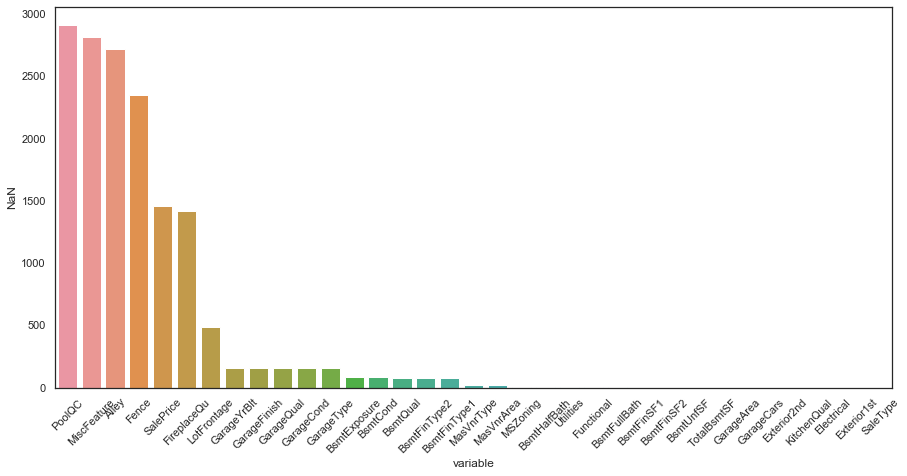

In [11]:
variables = list(stats[stats['NaN'] > 0].sort_values(by = ['NaN'], ascending = False).variable)
sns.barplot(x = 'variable', y='NaN', data = stats[stats['NaN'] > 0], order = variables)
plt.xticks(rotation=45)
stats[stats['NaN'] > 0].sort_values(by = ['NaN'], ascending = False)[['variable', 'NaN']]

Having detailed information about which variables have missing values and how many they are, we can treat these cases and replace the *NaN* values for other values that may be more adequate. Some things that I would like to highlight:

- One thing to notice is that the SalePrice variable has 1459 *NaN* values (the same number of rows in the test set). This is so because these are the values that we have to predict in this competition, so we are not dealing with those missing values now, they are our final goal;
- Checking the data_description.txt file we can see that most of these missing values actually indicates that the house doesn't have that feature. i.e. Missing values in the variable FireplaceQu indicates that the house doesn't have a fireplace. With this in mind I'll replace the missing values with a *NA* when in case of a categorical variable or I'll replace it with a *0* otherwise.

<h3>Direct transformation of NaN values into NA or into 0</h3>

For this reason, the following variables had their *NaN* values transformed:

- Alley, 
- BsmtCond, 
- BsmtExposure, 
- BsmtFinSF1, 
- BsmtFinSF2,
- BsmtFinType1, 
- BsmtFinType2, 
- BsmtFullBath,
- BsmtHalfBath,   
- BsmtQual, 
- BsmtUnfSF 
- Fence, 
- FireplaceQu, 
- GarageCond, 
- GarageFinish, 
- GarageQual, 
- GarageType,
- MiscFeature, 
- TotalBsmtSF.

In [12]:
dataset['MiscFeature'].fillna('NA', inplace = True)
dataset['Alley'].fillna('NA', inplace = True)
dataset['Fence'].fillna('NA', inplace = True)
dataset['FireplaceQu'].fillna('NA', inplace = True)
dataset['GarageFinish'].fillna('NA', inplace = True)
dataset['GarageQual'].fillna('NA', inplace = True)
dataset['GarageCond'].fillna('NA', inplace = True)
dataset['GarageType'].fillna('NA', inplace = True)
dataset['BsmtExposure'].fillna('NA', inplace = True)
dataset['BsmtCond'].fillna('NA', inplace = True)
dataset['BsmtQual'].fillna('NA', inplace = True)
dataset['BsmtFinType1'].fillna('NA', inplace = True)
dataset['BsmtFinType2'].fillna('NA', inplace = True)
dataset['BsmtFullBath'].fillna(0.0, inplace = True)
dataset['BsmtHalfBath'].fillna(0.0, inplace = True)
dataset['BsmtFinSF1'].fillna(0.0, inplace = True)
dataset['BsmtFinSF2'].fillna(0.0, inplace = True)
dataset['BsmtUnfSF'].fillna(0.0, inplace = True)
dataset['TotalBsmtSF'].fillna(0.0, inplace = True)

<h4>The following variables required some kind of additional evaluation before I could transform the missing values.</h4>

<h3>PoolQC</h3>

We can see in the stats dataset that PoolQC has 2909 missing values, but PoolArea has only 2906 zero values. So the 3 observations mismatched are real missing values. I'll check how is the crosstabulation between these two variables before decide what to do. 

In [13]:
dataset.PoolQC.value_counts()

Ex    4
Gd    4
Fa    2
Name: PoolQC, dtype: int64

In [14]:
pd.crosstab(dataset.PoolArea, dataset.PoolQC)

PoolQC,Ex,Fa,Gd
PoolArea,,,
144,1,0,0
228,1,0,0
480,0,0,1
512,1,0,0
519,0,1,0
555,1,0,0
576,0,0,1
648,0,1,0
738,0,0,1


In [15]:
dataset[(pd.isna(dataset['PoolQC'])) & (dataset['PoolArea'] > 0)].PoolArea.value_counts()

444    1
561    1
368    1
Name: PoolArea, dtype: int64

Checking the variables we can see that the range between each classification in PoolQC doesn't quite match the range of these missing values. Checking the description file we see that there is another category that is not present in this classification: 'TA' meaning 'Average/Typical'. We have no rule of thumb here. It seems reasonable to me to assume that the missing labes are 'TA' and for this reason I'm coding these three values as 'TA', but another acceptable approach would be to take the median of the PoolArea variable of each category in PoolQC and assign the missing observations to the category in PoolQC that is closer to its median value in PoolArea. In the end, the most important thing here is to don't mislabel these three cases as *NA*.

In [16]:
indexes = dataset[(pd.isna(dataset['PoolQC'])) & (dataset['PoolArea'] > 0)].index
dataset.loc[indexes, 'PoolQC'] = 'TA'
dataset['PoolQC'].fillna('NA', inplace = True)

<h3>LotFrontage</h3>

LotFrontage is going to need some manipulation since it is a numerical variable with several *NaN* values. Luckily it is related to other variables with characteristics of the lot. Let's check:
- LotArea;
- LotShape;
- LotConfig.

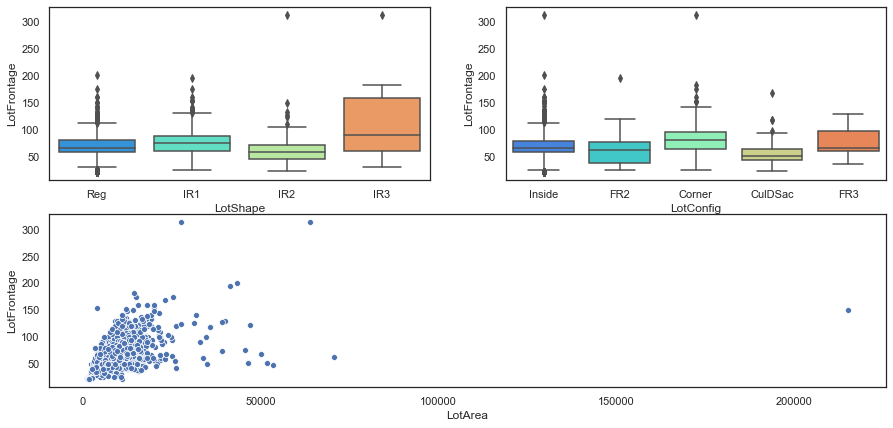

In [17]:
#fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1 = plt.subplot(212)
ax2 = plt.subplot(221)
ax3 = plt.subplot(222)
#plt.subplots_adjust(hspace = 0.5)

sns.scatterplot(y = 'LotFrontage', x = 'LotArea', data = dataset, ax = ax1, palette = 'rainbow')
sns.boxplot(y = 'LotFrontage', x = 'LotShape', data = dataset, ax = ax2, palette = 'rainbow')
sns.boxplot(y = 'LotFrontage', x = 'LotConfig', data = dataset, ax = ax3, palette = 'rainbow')

Looking at the variables we see that LotArea seems to be closer related to LotFrontage than the other variables. Yet, this relation doens't seem to be linear. I'll check it's correlation with this variable as it is, with its square root and with its fourth roth to see which of these transformations are more related to LotFrontage.

In [18]:
pearsonr(dataset.LotFrontage.dropna(), dataset[pd.notna(dataset['LotFrontage'])].LotArea)

(0.4898955703871666, 4.4552886823926206e-147)

In [19]:
pearsonr(dataset.LotFrontage.dropna(), np.power(dataset[pd.notna(dataset['LotFrontage'])].LotArea, 1/2))

(0.6476580398617829, 2.1604062346461675e-289)

In [20]:
pearsonr(dataset.LotFrontage.dropna(), np.power(dataset[pd.notna(dataset['LotFrontage'])].LotArea, 1/4))

(0.6765144577384584, 0.0)

The fourth root of Lot Area is closer related to LotFrontage and for this reason I'll use it to fill in the missing values in LotFrontage.

Below I present the distribution of the fourth root of LotArea:

[Text(0.5, 0, 'Fourth root of LotArea')]

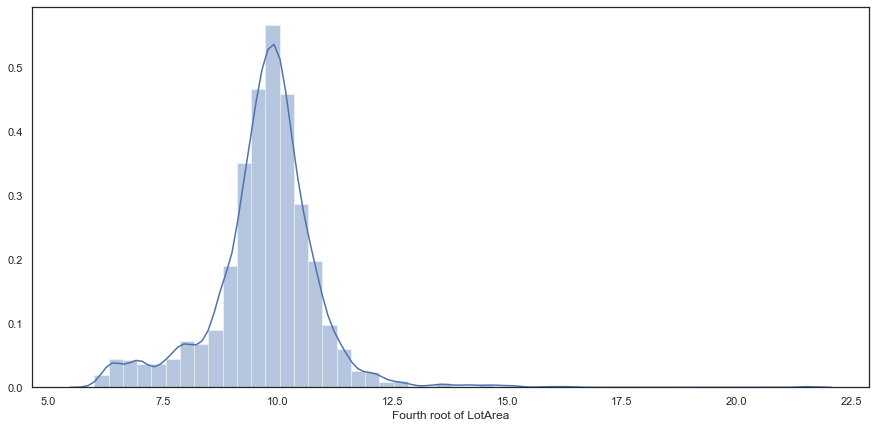

In [21]:
ax = sns.distplot(np.power(dataset[pd.notna(dataset['LotFrontage'])].LotArea, 1/4))
ax.set(xlabel = 'Fourth root of LotArea')

The missing values will be fit on the regression line presented next in the scatterplot:

[Text(0.5, 0, 'Fourth root of LotArea')]

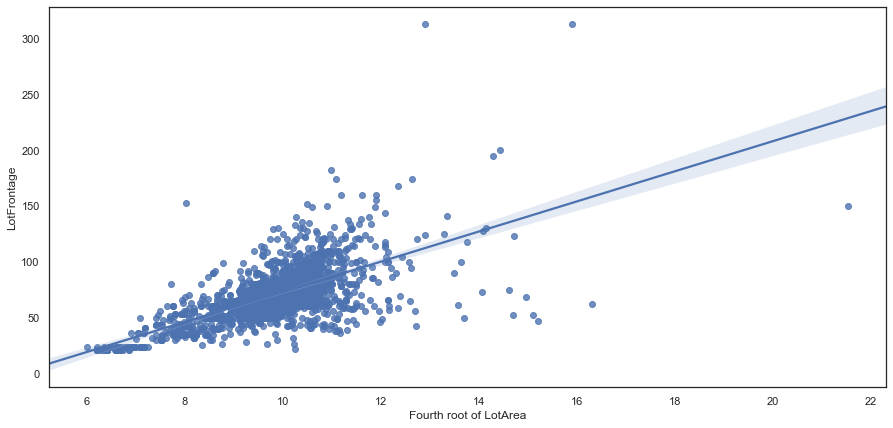

In [22]:
ax = sns.regplot(y=dataset.LotFrontage.dropna(), x=np.power(dataset[pd.notna(dataset['LotFrontage'])].LotArea, 1/4))
ax.set(xlabel = 'Fourth root of LotArea')

Ok. So I'll use a robust regression model to predict the values in the missing observations.

In [23]:
X = np.power(dataset[pd.notna(dataset['LotFrontage'])].LotArea, 1/4)
X = sm.add_constant(X)
model = sm.RLM(dataset.LotFrontage.dropna(), X)
results = model.fit()

In [24]:
index = dataset[pd.isna(dataset['LotFrontage'])].index
X_test = np.power(dataset.loc[index, 'LotArea'], 1/4)
X_test = sm.add_constant(X_test)
dataset.loc[index, 'LotFrontage'] = results.predict(X_test)

[Text(0.5, 0, 'Fourth root of LotArea')]

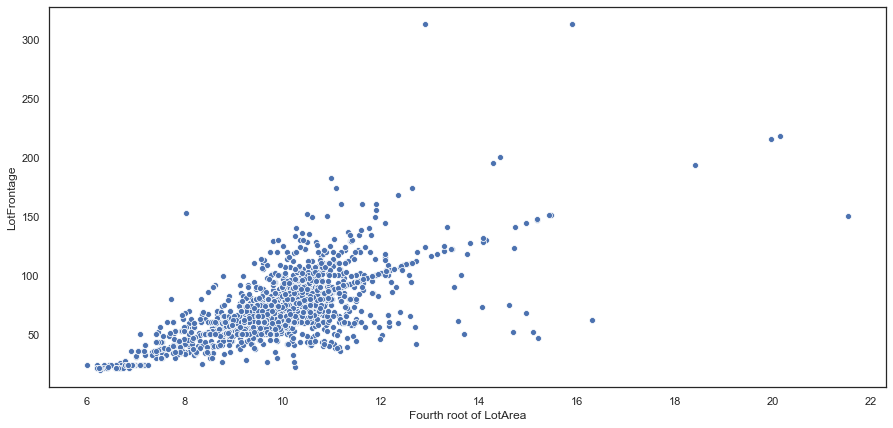

In [25]:
ax = sns.scatterplot(y=dataset.LotFrontage, x=np.power(dataset.LotArea, 1/4))
ax.set(xlabel = 'Fourth root of LotArea')

That's it.

<h3>GarageYrBlt</h3>

Since this is a numeric variable, if I just fill in its *NaN* values with a *zero* I can end up inserting a serious bias in the variable. It seems more reasonable to find another variable that is correlated with GarageYrBlt and see how I can manipulate both so I can fill in these gaps without harming my future models. For this reason, I'm checking its correlation with the YearBuilt variable.

In [26]:
pearsonr(dataset.GarageYrBlt.dropna(), dataset[pd.notna(dataset['GarageYrBlt'])].YearBuilt)

(0.8348123731631004, 0.0)

Since these variables have a strong correlation, lets plot them together:

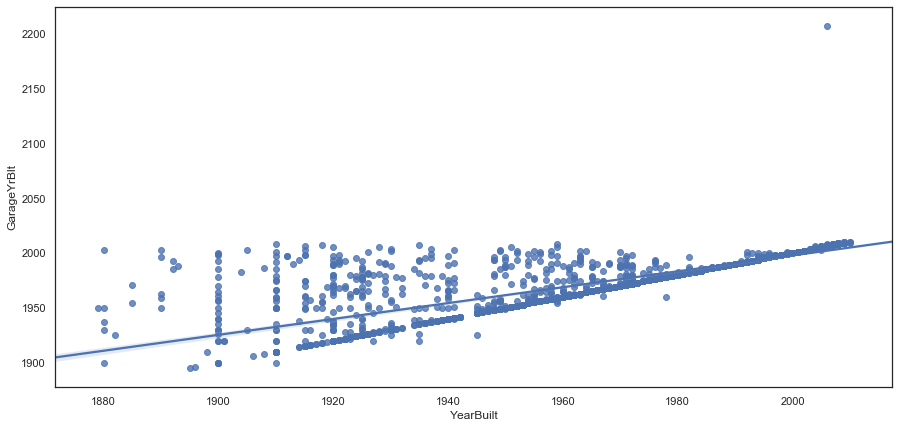

In [27]:
sns.regplot(y = dataset.GarageYrBlt.dropna(), x = dataset[pd.notna(dataset['GarageYrBlt'])].YearBuilt)

Great! We can visualize the strong relation in the data and yet we see that there is a mislabelled observation in GarageYrBlt (the one with GarageYrBlt > 2200). To avoid that the mislabelled observation in GarageYrBlt insert a bias in the model, I'm going to replace it with a *NaN* value and then I'm going to create a linear model to predict the values in all the *NaN* observations in the GarageYrBlt variable.

In [28]:
index = dataset[dataset['GarageYrBlt'] > 2200].index
dataset.loc[index, 'GarageYrBlt'] = np.nan

In [29]:
# Fits the Regression Model.
X = dataset[pd.notna(dataset['GarageYrBlt'])]['YearBuilt']
X = sm.add_constant(X)
model = sm.OLS(dataset.GarageYrBlt.dropna(), X)
results = model.fit()

In [30]:
# Fill in the NaN values.
index = dataset[pd.isna(dataset['GarageYrBlt'])].index
X_test = dataset.loc[index, 'YearBuilt']
X_test = sm.add_constant(X_test)
X_test
dataset.loc[index, 'GarageYrBlt'] = round(results.predict(X_test),0).astype(int)

The regression line in the previous plot suggests that in the more recent years GarageYrBlt might have a smaller value than YearBuilt. I'll check it:

In [31]:
dataset[(dataset['GarageYrBlt'] < dataset['YearBuilt'])][['GarageYrBlt', 'YearBuilt']]

,GarageYrBlt,YearBuilt
29,1920.0,1927
89,1993.0,1994
93,1900.0,1910
148,2000.0,2004
324,1961.0,1967
600,2003.0,2005
613,2003.0,2007
736,1949.0,1950
1103,1954.0,1959
1376,1925.0,1930


Ok. Is easy to see when the model filled the missing values. These observations, in recent years, are the ones where GarageYrBlt is equal to YearBuilt minus 4. In these cases, I'll make GarageYrBlt equal to YearBuilt. I'm calling 'recent years' anything that came after 2000 (counting the year 2000).   

In [32]:
dataset['GarageYrBlt'] = np.where((dataset['GarageYrBlt'] >= 2000) & (dataset['GarageYrBlt'] == dataset['YearBuilt'] - 4), dataset['YearBuilt'], dataset['GarageYrBlt'])

<h3>MasVnrType and MasVnrArea</h3>

There is one more observation in the MasVnrType variable counting as *NaN* then there is in the MasVnrArea variable. So that observation is very likely to be mislabelled. To fix it, I'll check what are the means of the MasVnrArea variable when grouped by the categories in MasVnrType and I'll choose the category with the median in MasVnrArea closest to the value in the observation with mislabelled data.

In [33]:
dataset[(pd.notna(dataset['MasVnrArea'])) & (pd.isna(dataset['MasVnrType']))][['MasVnrArea', 'MasVnrType']]

,MasVnrArea,MasVnrType
2610,198.0,NaN


In [34]:
dataset.groupby('MasVnrType', as_index = False)['MasVnrArea'].median()

,MasVnrType,MasVnrArea
0,BrkCmn,161.0
1,BrkFace,203.0
2,None,0.0
3,Stone,200.0


In [35]:
index = dataset[(pd.notna(dataset['MasVnrArea'])) & (pd.isna(dataset['MasVnrType']))].index
dataset.loc[index, 'MasVnrType'] = 'Stone'

Now that we have the same number of *NaN* in both variables, we can set them equal to *NA* and zero.

In [36]:
dataset['MasVnrType'].fillna('NA', inplace = True)
dataset['MasVnrArea'].fillna(0, inplace = True)

<h3>MSZoning</h3>

According to the description file, there should be no *NaN* in this variable. To fix this, I'll compare the values in this variable with the values in MSSubClass and in LotArea (since the lot area may be influenced by the zoning classification of the sale). I'll choose the MSZoning value according to the category in MSSubClass of the observations with *NaN* values in the variable MSZoning and according to the LotArea closer to the median of LotArea of the observations grouped by MSSubClass.

In [37]:
# LotArea and MSSubClass of the observations with NaN in the MSZoning variable.
dataset[pd.isna(dataset['MSZoning'])][['MSSubClass', 'LotArea']]

,MSSubClass,LotArea
1915,30,21780
2216,20,14584
2250,70,56600
2904,20,31250


In [38]:
# median LotArea grouped by MSZoning and MSSubClass.
temp = dataset.groupby(['MSSubClass', 'MSZoning'], as_index=False)['LotArea'].median()
temp[temp['MSSubClass'].isin([20, 30, 70])]

,MSSubClass,MSZoning,LotArea
0,20,C (all),8712.0
1,20,FV,8640.0
2,20,RH,8650.0
3,20,RL,10181.0
4,20,RM,7821.0
5,30,C (all),9052.0
6,30,RH,7035.0
7,30,RL,8550.0
8,30,RM,6324.0
21,70,C (all),7474.5


In [39]:
# Makes the substitutions.
indexes = dataset[(pd.isna(dataset['MSZoning'])) & (dataset['MSSubClass'] == 30)].index
dataset.loc[indexes, 'MSZoning'] = 'C (all)'
indexes = dataset[pd.isna(dataset['MSZoning'])].index
dataset.loc[indexes, 'MSZoning'] = 'RL'

In [40]:
dataset['MSZoning'].value_counts()

RL         2268
RM          460
FV          139
RH           26
C (all)      26
Name: MSZoning, dtype: int64

<h3>Utilities</h3>

Let's check the distribution of this variable.

In [41]:
dataset['Utilities'].value_counts()

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

Ok. So it's no brainer in which category the missing values should be classified in.

In [42]:
dataset['Utilities'].fillna('AllPub', inplace = True)

<h3>Functional</h3>

Let's check the distribution of this variable.

In [43]:
dataset['Functional'].value_counts()

Typ     2717
Min2      70
Min1      65
Mod       35
Maj1      19
Maj2       9
Sev        2
Name: Functional, dtype: int64

Ok. I guess it's reasonable to classify the missing values as 'Typ'.

In [44]:
dataset['Functional'].fillna('Typ', inplace = True)

<h3>GarageArea</h3>

Let's check this variable.

In [45]:
dataset['GarageArea'].value_counts()

0.0      157
576.0     97
440.0     96
240.0     69
484.0     68
        ... 
443.0      1
424.0      1
263.0      1
962.0      1
803.0      1
Name: GarageArea, Length: 603, dtype: int64

In [46]:
dataset[pd.isna(dataset['GarageArea'])]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,dataset
2576,2577,70,RM,50.0,9060,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NA,Detchd,1942.0,NA,NaN,NaN,NA,NA,Y,174,0,212,0,0,0,NA,MnPrv,NA,0,3,2007,WD,Alloca,NaN,test


In [47]:
dataset[dataset['GarageType'] == 'Detchd'].GarageArea.describe()

count     778.000000
mean      419.492288
std       174.726572
min       100.000000
25%       280.000000
50%       399.500000
75%       528.000000
max      1488.000000
Name: GarageArea, dtype: float64

I'll set this *NaN* observation equal to the median value of the variable GarageArea when the GarageType is equal to 'Detchd'.

In [48]:
dataset['GarageArea'].fillna(399, inplace = True)

<h3>GarageCars</h3>

In [49]:
dataset['GarageCars'].value_counts()

2.0    1594
1.0     776
3.0     374
0.0     157
4.0      16
5.0       1
Name: GarageCars, dtype: int64

In [50]:
dataset[pd.isna(dataset['GarageCars'])]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,dataset
2576,2577,70,RM,50.0,9060,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,IDOTRR,Norm,Norm,1Fam,2Story,5,6,1923,1999,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,BrkTil,Gd,TA,No,ALQ,548.0,Unf,0.0,311.0,859.0,GasA,Ex,Y,SBrkr,942,886,0,1828,0.0,0.0,2,0,3,1,Gd,6,Typ,0,NA,Detchd,1942.0,NA,NaN,399.0,NA,NA,Y,174,0,212,0,0,0,NA,MnPrv,NA,0,3,2007,WD,Alloca,NaN,test


In [51]:
temp = dataset.groupby(['GarageType', 'GarageCars'], as_index=False)['GarageArea'].median()
temp[temp['GarageType'] == 'Detchd']

,GarageType,GarageCars,GarageArea
17,Detchd,1.0,273.0
18,Detchd,2.0,528.0
19,Detchd,3.0,792.0
20,Detchd,4.0,916.0
21,Detchd,5.0,1184.0


It seems reasonable to assume that the GarageArea is equal to 1 or 2. I'll be pragmatic here and choose the one with the median Area closer to 399.

In [52]:
dataset['GarageCars'].fillna(1, inplace = True)

<h3>Exterior1st and Exterior2nd</h3>

In [53]:
dataset[pd.isna(dataset['Exterior2nd'])]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,dataset
2151,2152,30,RL,85.0,19550,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,1Fam,1Story,5,7,1940,2007,Flat,Tar&Grv,NaN,NaN,None,0.0,TA,TA,PConc,TA,TA,Gd,ALQ,1035.0,Unf,0.0,545.0,1580.0,GasA,Ex,Y,SBrkr,1518,0,0,1518,1.0,0.0,1,0,2,1,Fa,5,Typ,2,Gd,NA,1954.0,NA,0.0,0.0,NA,NA,Y,0,39,0,0,0,0,NA,NA,NA,0,1,2008,WD,Normal,NaN,test


Both missing values of both variables are in the same line. I'll check some crosstabulations:

In [54]:
pd.crosstab(dataset['Exterior1st'], dataset['ExterCond'])

ExterCond,Ex,Fa,Gd,Po,TA
Exterior1st,,,,,
AsbShng,0,7,4,1,32
AsphShn,0,1,0,0,1
BrkComm,0,1,0,0,5
BrkFace,0,2,7,0,78
CBlock,0,1,0,0,1
CemntBd,0,0,8,0,118
HdBoard,0,7,34,1,400
ImStucc,0,0,0,0,1
MetalSd,3,12,75,0,360


In [55]:
pd.crosstab(dataset['Exterior2nd'], dataset['ExterCond'])

ExterCond,Ex,Fa,Gd,Po,TA
Exterior2nd,,,,,
AsbShng,0,7,2,0,29
AsphShn,0,1,0,0,3
Brk Cmn,0,1,0,0,21
BrkFace,0,1,4,0,42
CBlock,0,0,0,0,3
CmentBd,0,0,9,0,117
HdBoard,0,6,37,1,362
ImStucc,0,0,0,0,15
MetalSd,4,13,74,0,356


The numbers don't change very much from one table to the other. This suggests that there must be many cases in which both variables have the same values. Let's see if this is true: 

In [56]:
len(dataset[dataset['Exterior1st'] == dataset['Exterior2nd']])

2481

Indeed, in most of the cases both variables have the same value. Since 'VinylSd' is the the most common value for both variables, I'm setting the missing value in both variables equal to 'VinylSd'.

In [57]:
dataset['Exterior1st'].fillna('VinylSd', inplace = True)
dataset['Exterior2nd'].fillna('VinylSd', inplace = True)

<h3>KitchenQual</h3>

In [58]:
dataset[pd.isna(dataset['KitchenQual'])]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,dataset
1555,1556,50,RL,72.0,10632,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,ClearCr,Norm,Norm,1Fam,1.5Fin,5,3,1917,1950,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,TA,BrkTil,Gd,Fa,No,Unf,0.0,Unf,0.0,689.0,689.0,GasA,Gd,N,SBrkr,725,499,0,1224,0.0,0.0,1,1,3,1,NaN,6,Mod,0,NA,Detchd,1917.0,Unf,1.0,180.0,Fa,Fa,N,0,0,248,0,0,0,NA,NA,NA,0,1,2010,COD,Normal,NaN,test


In [59]:
dataset[dataset['KitchenAbvGr'] ==  1].KitchenQual.value_counts()

TA    1372
Gd    1146
Ex     205
Fa      61
Name: KitchenQual, dtype: int64

In [60]:
dataset['KitchenQual'].fillna('TA', inplace = True)

<h3>Electrical</h3>

In [61]:
dataset['Electrical'].value_counts()

SBrkr    2671
FuseA     188
FuseF      50
FuseP       8
Mix         1
Name: Electrical, dtype: int64

In [62]:
dataset['Electrical'].fillna('SBrkr', inplace = True)

<h3>SaleType</h3>

In [63]:
dataset[pd.isna(dataset['SaleType'])]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,dataset
2489,2490,20,RL,85.0,13770,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,Sawyer,Feedr,Norm,1Fam,1Story,5,6,1958,1998,Gable,CompShg,Plywood,Plywood,BrkFace,340.0,TA,TA,CBlock,TA,TA,Mn,Rec,190.0,BLQ,873.0,95.0,1158.0,GasA,TA,Y,SBrkr,1176,0,0,1176,1.0,0.0,1,0,3,1,TA,6,Typ,2,Gd,Attchd,1958.0,Unf,1.0,303.0,TA,TA,Y,0,0,0,0,0,0,NA,NA,NA,0,10,2007,NaN,Normal,NaN,test


In [64]:
dataset[dataset['SaleCondition'] == 'Normal'].SaleType.value_counts()

WD       2314
COD        39
ConLD      21
CWD        10
ConLw       7
ConLI       5
Con         4
Oth         1
Name: SaleType, dtype: int64

In [65]:
dataset['SaleType'].fillna('WD', inplace = True)

<h3>SalePrice - Variable Transformation</h3>

This variable statistics in the stats table strongly suggest that this variable is skewed to the left. Being this the case, it is recommended to log-transform SalePrice so that its distribution become more like a normal distribution, helping our dependent variable meet some assumptions made in inferential statistics.

Let's check SalePrice distribution as it is:

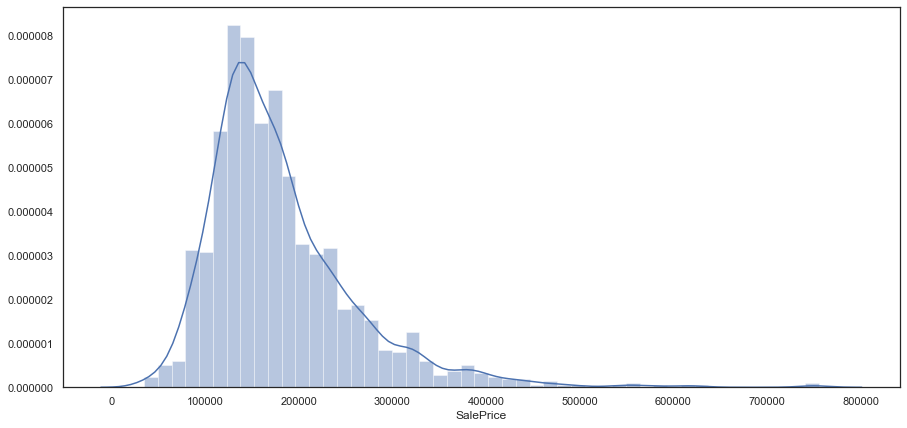

In [66]:
sns.distplot(dataset.SalePrice.dropna())

Lets check its distribution after log transformation:

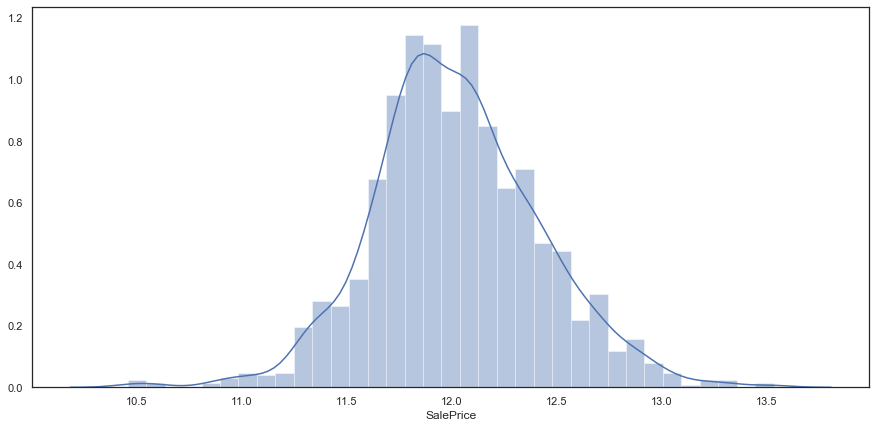

In [67]:
sns.distplot(np.log(dataset.SalePrice.dropna()), hist=True)

Comparing both distributions we can see that the log transformed variable seems closer to a normal distribution than the original data and for this reason I'm going to work with the log transformed variable in my regression models.

In [68]:
index = dataset[pd.notna(dataset['SalePrice'])].index
dataset.loc[index, 'SalePriceLog'] = np.log(dataset.loc[index, 'SalePrice'])

<h2>Data Transformations</h2>

The distribution of some variables suggest us that some transformations may be adequate to the regression models, depending on the model we choose to work with. Whith this in mind I'll update the stats dataset and I'll use it to help me decide which variables should be transformed, or created.

In [69]:
stats = dataset.describe().T
for i in range(len(dataset.columns)):
    stats.loc[dataset.columns[i], 'mode'], stats.loc[dataset.columns[i], 'mode_count'] = mode(dataset[dataset.columns[i]])
    stats.loc[dataset.columns[i], 'unique_values'] = dataset[dataset.columns[i]].value_counts().size
    stats.loc[dataset.columns[i], 'NaN'] = dataset[dataset.columns[i]].isnull().sum()
    if np.isnan(stats.loc[dataset.columns[i], 'count']): 
        stats.loc[dataset.columns[i], 'count'] = dataset.shape[0] - stats.loc[dataset.columns[i], 'NaN']
stats = stats[['count', 'NaN', 'unique_values', 'mode', 'mode_count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
stats.index.name = 'variable'
stats.reset_index(inplace = True)
stats

,variable,count,NaN,unique_values,mode,mode_count,mean,std,min,25%,50%,75%,max
0,Id,2919.0,0.0,2919.0,1,1.0,1460.000000,842.787043,1.000000,730.500000,1460.000000,2189.500000,2919.000000
1,MSSubClass,2919.0,0.0,16.0,20,1079.0,57.137718,42.517628,20.000000,20.000000,50.000000,70.000000,190.000000
2,LotFrontage,2919.0,0.0,567.0,60,276.0,70.352824,23.092628,19.536867,60.000000,70.000000,80.000000,313.000000
3,LotArea,2919.0,0.0,1951.0,9600,44.0,10168.114080,7886.996359,1300.000000,7478.000000,9453.000000,11570.000000,215245.000000
4,OverallQual,2919.0,0.0,10.0,5,825.0,6.089072,1.409947,1.000000,5.000000,6.000000,7.000000,10.000000
5,OverallCond,2919.0,0.0,9.0,5,1645.0,5.564577,1.113131,1.000000,5.000000,5.000000,6.000000,9.000000
6,YearBuilt,2919.0,0.0,118.0,2005,142.0,1971.312778,30.291442,1872.000000,1953.500000,1973.000000,2001.000000,2010.000000
7,YearRemodAdd,2919.0,0.0,61.0,1950,361.0,1984.264474,20.894344,1950.000000,1965.000000,1993.000000,2004.000000,2010.000000
8,MasVnrArea,2919.0,0.0,444.0,0,1761.0,101.396026,178.854579,0.000000,0.000000,0.000000,163.500000,1600.000000
9,BsmtFinSF1,2919.0,0.0,991.0,0,930.0,441.272011,455.606014,0.000000,0.000000,368.000000,733.000000,5644.000000


Some observations based on the table presented previously:
- The variables *MoSold, MSSubClass, OverallCond* and *OverallQual* may work better in a regression model if coded as **categorical variables**. For this reason I'll change them to be treated as categorical;
- Some variables with no values equal to zero could perform better in a regression model if **log transformed** since they are skewed and a transformation could help prevent problems of multicolinearity: 
    - MSSubClass; 
    - LotFrontage; 
    - LotArea; 
    - 1stFlrSF; 
    - GrLivArea.
- Some other variables can be used to generate new **dummy variables** indicating the presence/absence of certain features:
    - 2ndFlrSF;
    - 3SsnPorch;
    - Alley;
    - EnclosedPorch;
    - Fence;
    - FireplaceQu;
    - GarageQual;
    - LowQualFinSF;
    - MasVnrType;
    - MiscFeature;
    - MiscVal;
    - PoolQC;
    - OpenPorchSF;
    - ScreenPorch
    - TotalBsmtSF;
    - WoodDeckSF.
- Some variables can be generated from the existing ones:
    - YrBltAndRemod = YearBuilt + YearRemodAdd
    - TotalSF = TotalBsmtSF + 1stFlrSF + 2ndFlrSF
    - Total_sqr_footage = BsmtFinSF1 + BsmtFinSF2 + 1stFlrSF +  2ndFlrSF
    - Total_Bathrooms = FullBath + 0.5 * HalfBath + BsmtFullBath + 0.5 * BsmtHalfBath
    - Total_porch_sf = OpenPorchSF +  3SsnPorch + EnclosedPorch + ScreenPorch + WoodDeckSF

First I'll convert the above mentioned variables into string types.

In [70]:
dataset['MoSold'] = dataset['MoSold'].astype(str)
dataset['MSSubClass'] = dataset['MSSubClass'].astype(str)
dataset['OverallCond'] = dataset['OverallCond'].astype(str)
dataset['OverallQual'] = dataset['OverallQual'].astype(str)

Now I make the log transformation of the following variables: *LotFrontage, LotArea, 1stFlrSF* and *GrLivArea*.

In [71]:
dataset['LotFrontageLog'] = np.log(dataset['LotFrontage'])
dataset['LotAreaLog'] = np.log(dataset['LotArea'])
dataset['1stFlrSFLog'] = np.log(dataset['1stFlrSF'])
dataset['GrLivAreaLog'] = np.log(dataset['GrLivArea'])

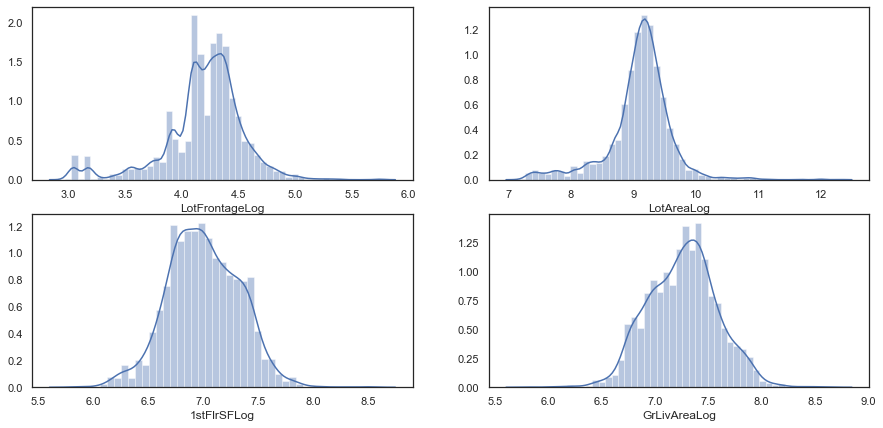

In [72]:
ax1 = plt.subplot(221)
ax2 = plt.subplot(222)
ax3 = plt.subplot(223)
ax4 = plt.subplot(224)

sns.distplot(dataset['LotFrontageLog'], ax = ax1)
sns.distplot(dataset['LotAreaLog'], ax = ax2)
sns.distplot(dataset['1stFlrSFLog'], ax = ax3)
sns.distplot(dataset['GrLivAreaLog'], ax = ax4)

Now, I create dummy variables to indicate the presence/absence of some features in the houses.

In [73]:
dataset['2ndFlrDummy'] = np.where(dataset['2ndFlrSF'] > 0, 1, 0)
dataset['3SsnPorchDummy'] = np.where(dataset['3SsnPorch'] > 0, 1, 0)
dataset['AlleyDummy'] = np.where(dataset['Alley'] != 'NA', 1, 0)
dataset['EnclosedPorchDummy'] = np.where(dataset['EnclosedPorch'] > 0, 1, 0)
dataset['FireplaceDummy'] = np.where(dataset['FireplaceQu'] != 'NA', 1, 0)
dataset['LowQualFinDummy'] = np.where(dataset['LowQualFinSF'] > 0, 1, 0)
dataset['OpenPorchDummy'] = np.where(dataset['OpenPorchSF'] > 0, 1, 0)
dataset['PoolDummy'] = np.where(dataset['PoolQC'] != 'NA', 1, 0)
dataset['ScreenPorchDummy'] = np.where(dataset['ScreenPorch'] > 0, 1, 0)
dataset['PorchDummy'] = np.where(dataset['3SsnPorchDummy'] + dataset['EnclosedPorchDummy'] + dataset['OpenPorchDummy'] + dataset['ScreenPorchDummy'] > 0, 1, 0)
dataset['BsmtDummy'] = np.where(dataset['TotalBsmtSF'] > 0, 1, 0)
dataset['DeckDummy'] = np.where(dataset['WoodDeckSF'] > 0, 1, 0)

Finally, I create the new variables and some of their log variables.

In [74]:
dataset['YrBltAndRemod'] = dataset['YearBuilt'] + dataset['YearRemodAdd']
dataset['TotalSF'] = dataset['TotalBsmtSF'] + dataset['1stFlrSF'] + dataset['2ndFlrSF']
dataset['Total_sqr_footage'] = dataset['BsmtFinSF1'] + dataset['BsmtFinSF2'] + dataset['1stFlrSF'] + dataset['2ndFlrSF']
dataset['Total_Bathrooms'] = dataset['FullBath'] + 0.5 * dataset['HalfBath'] + dataset['BsmtFullBath'] + 0.5 * dataset['BsmtHalfBath']
dataset['Total_porch_sf'] = dataset['OpenPorchSF'] + dataset['3SsnPorch'] + dataset['EnclosedPorch'] + dataset['ScreenPorch'] + dataset['WoodDeckSF']

dataset['TotalSFLog'] = dataset['TotalSF']
dataset['Total_sqr_footageLog'] = dataset['Total_sqr_footage']
dataset['Total_porch_sfLog'] = dataset['Total_porch_sf']

<h2>Final look at the data</h2>

This is a final look at the dataset before implementing the regression models.

Here I try to have an idea of how each variable interact with the dependent variable of my future models: SalePriceLog.

<h3>Correlation Matrix</h3>

I'll start by checking for some correlations to have an idea of which variables are more likely to contribute to a regression model and which aren't. 

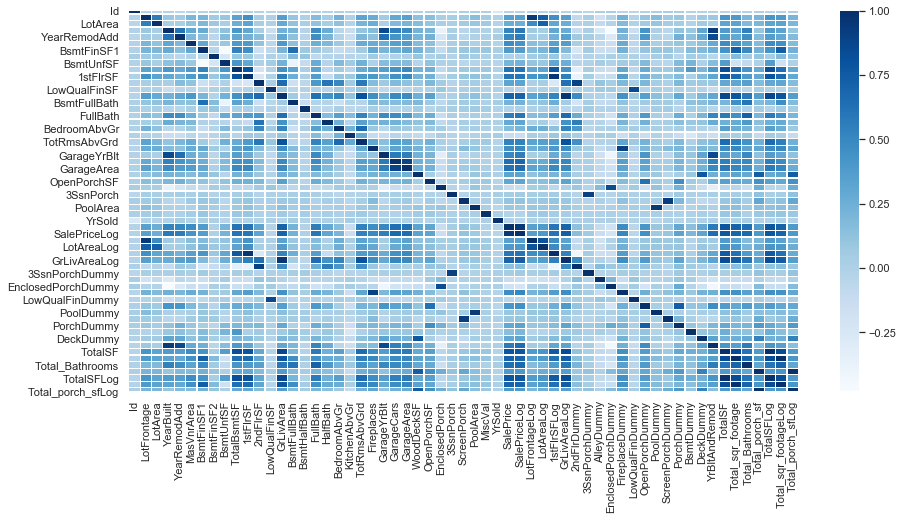

In [75]:
sns.heatmap(dataset.corr(), cmap="Blues", linewidths = .2)

Since there are many variables in the dataset, I think an easier way of checking for correlations with the dependent variable its to just check the columns SalePrice and SalePriceLog in the correlation matrix.

In [76]:
dataset.corr()['SalePrice'].sort_values(ascending = False)

SalePrice               1.000000
SalePriceLog            0.948374
TotalSF                 0.782260
TotalSFLog              0.782260
GrLivArea               0.708624
Total_sqr_footage       0.708047
Total_sqr_footageLog    0.708047
GrLivAreaLog            0.695118
GarageCars              0.640409
Total_Bathrooms         0.631731
GarageArea              0.623431
TotalBsmtSF             0.613581
1stFlrSF                0.605852
1stFlrSFLog             0.591264
YrBltAndRemod           0.576144
FullBath                0.560664
TotRmsAbvGrd            0.533723
YearBuilt               0.522897
YearRemodAdd            0.507101
GarageYrBlt             0.502352
MasVnrArea              0.472614
FireplaceDummy          0.471908
Fireplaces              0.466929
OpenPorchDummy          0.412959
Total_porch_sfLog       0.390993
Total_porch_sf          0.390993
LotAreaLog              0.388520
BsmtFinSF1              0.386420
LotFrontage             0.343026
LotFrontageLog          0.341040
WoodDeckSF

In [77]:
dataset.corr()['SalePriceLog'].sort_values(ascending = False)

SalePriceLog            1.000000
SalePrice               0.948374
TotalSF                 0.777296
TotalSFLog              0.777296
GrLivAreaLog            0.730255
GrLivArea               0.700927
Total_sqr_footage       0.698492
Total_sqr_footageLog    0.698492
GarageCars              0.680625
Total_Bathrooms         0.673011
GarageArea              0.650888
YrBltAndRemod           0.644833
TotalBsmtSF             0.612134
1stFlrSFLog             0.608947
1stFlrSF                0.596981
FullBath                0.594771
YearBuilt               0.586570
YearRemodAdd            0.565608
GarageYrBlt             0.553515
TotRmsAbvGrd            0.534422
FireplaceDummy          0.510026
Fireplaces              0.489449
OpenPorchDummy          0.449220
MasVnrArea              0.426775
LotAreaLog              0.399918
Total_porch_sfLog       0.398387
Total_porch_sf          0.398387
BsmtFinSF1              0.372023
LotFrontageLog          0.358558
LotFrontage             0.350409
WoodDeckSF

<h3>Visualizations</h3>

Some variables didn't appear in the previous correlation analysis because they are categorical.
To have an ideia of how they interact with the dependent variable I'll plot scatterplots of the numerical variables and scatterplots of the categorical variables. The Y axis is always SalePriceLog (the same visualizations can be generated to SalePrice by only replacing SalePriceLog by it in the code below).

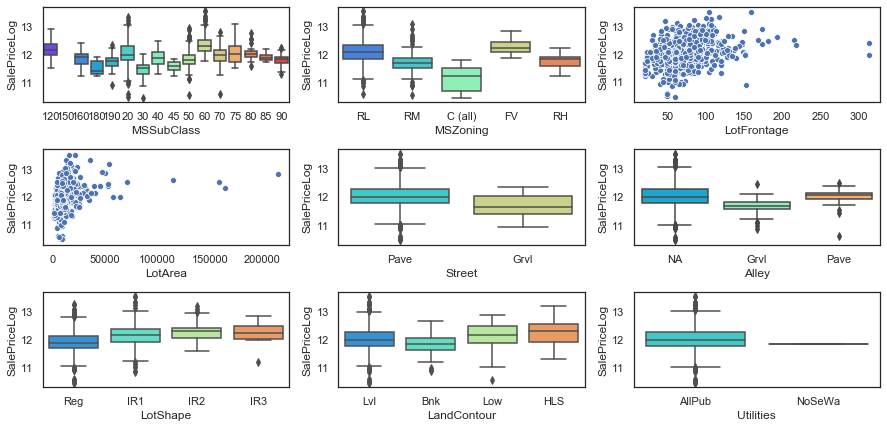

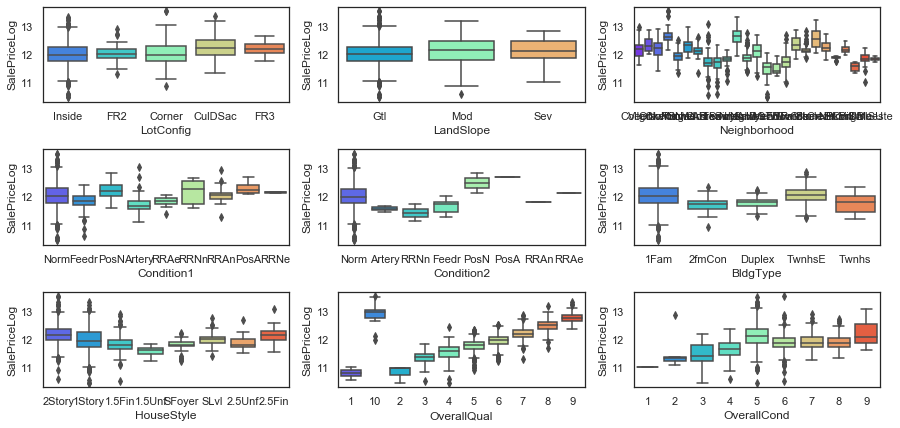

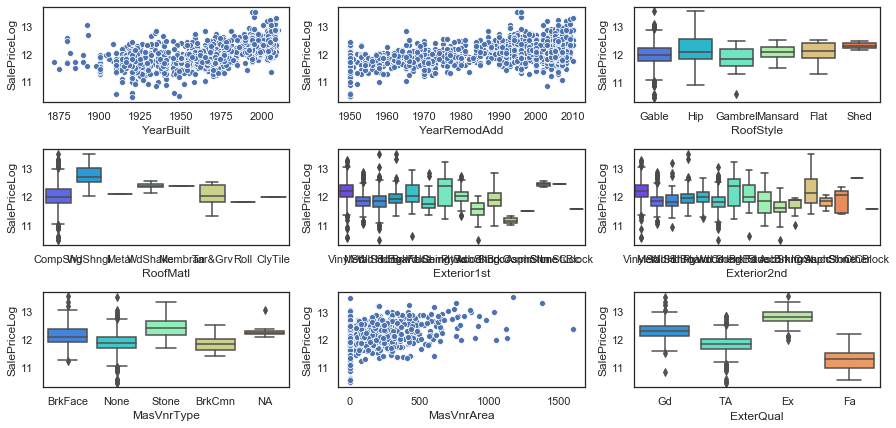

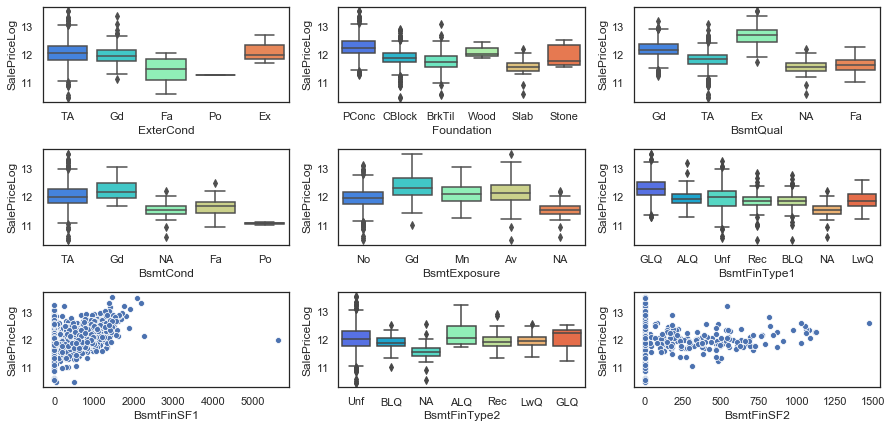

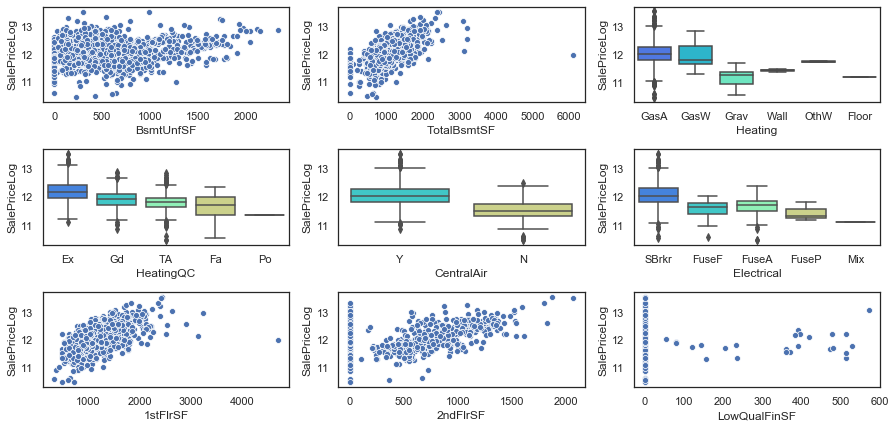

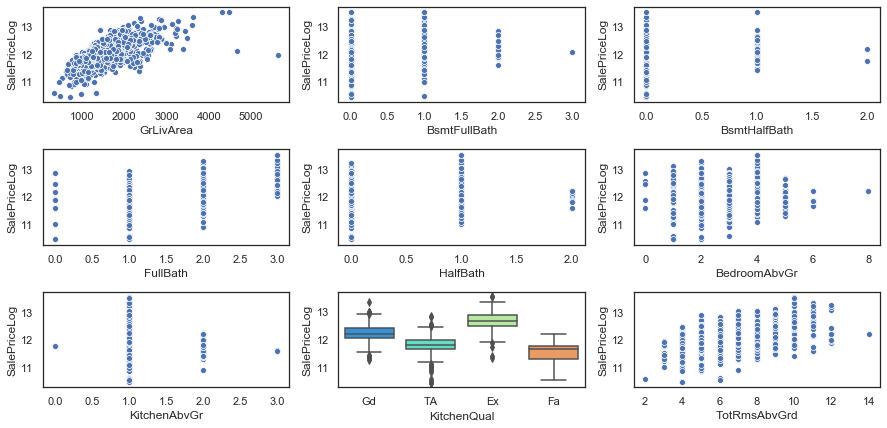

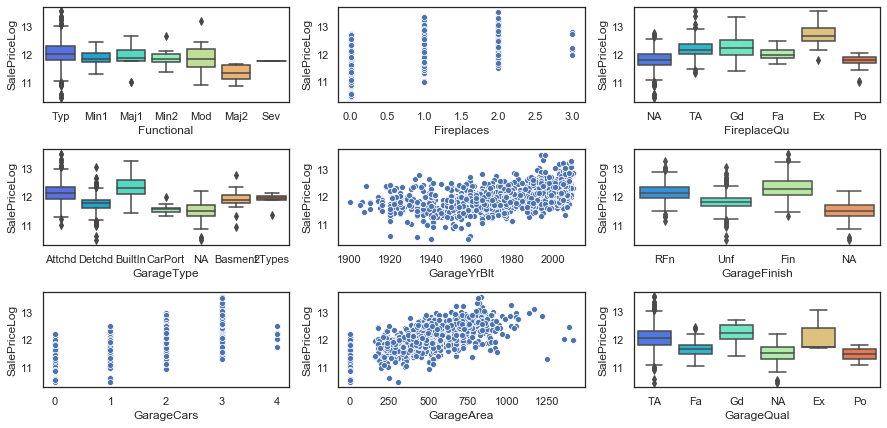

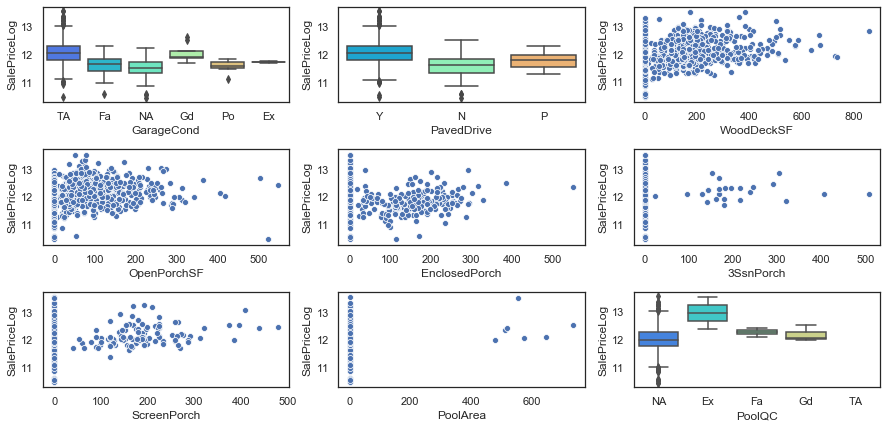

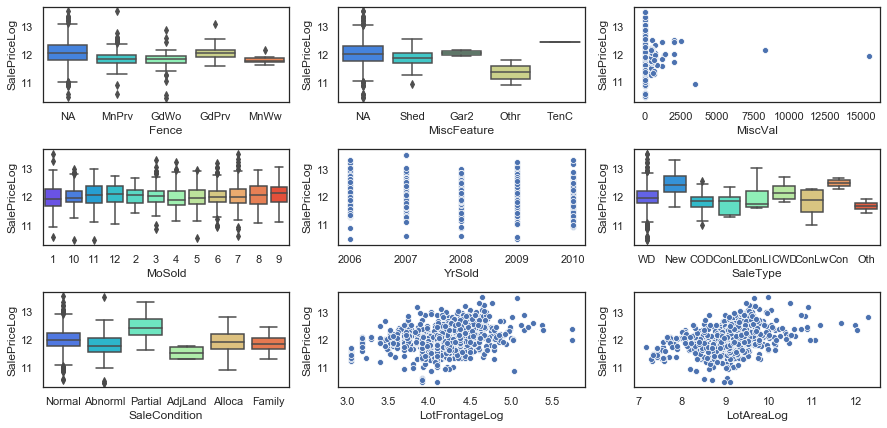

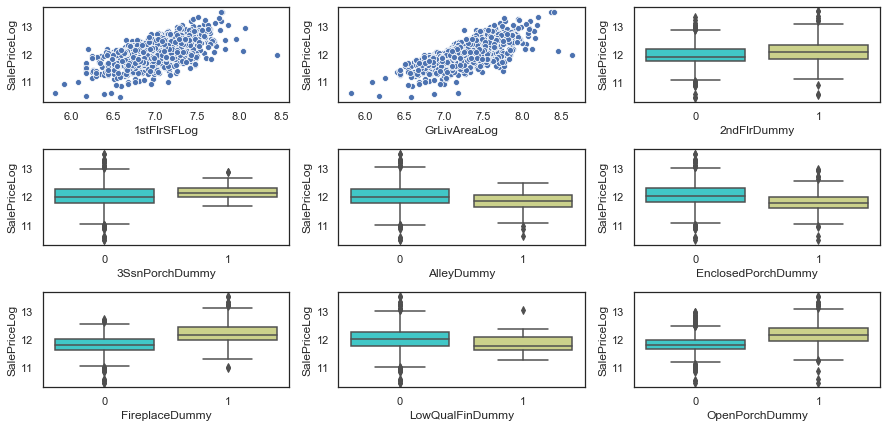

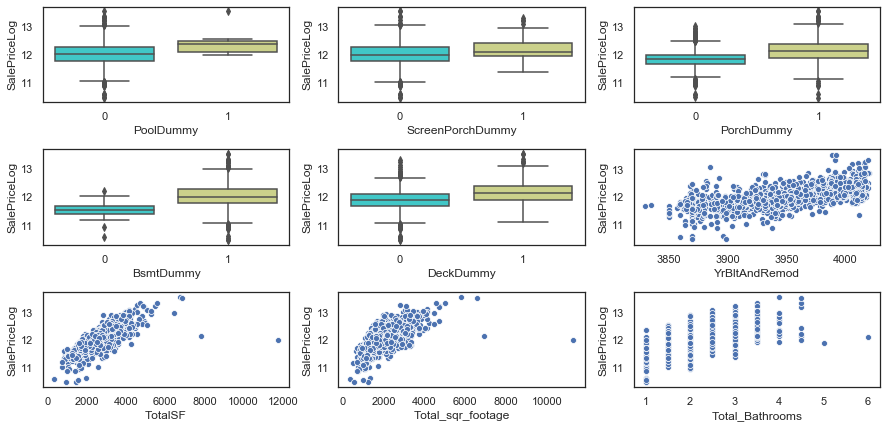

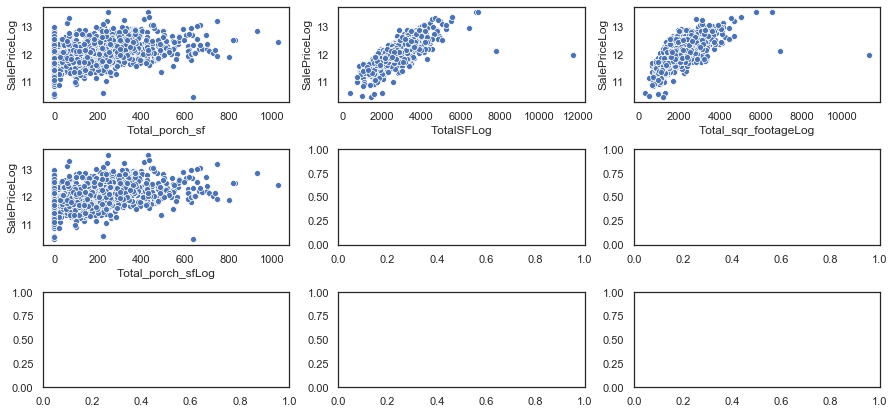

In [78]:
variables = list(dataset.columns)[1:80] + list(dataset.columns)[83:]

while len(variables) > 0:
    fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3, 3)
    plt.subplots_adjust(hspace = 0.5)
    ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]
    for i in range(9):
        if len(variables) > i:
            if type(dataset[variables[i]][0]) in [np.int64, np.float64]:
                sns.scatterplot(y = 'SalePriceLog', x = variables[i], data = dataset, ax = ax[i])
            else:
                sns.boxplot(y = 'SalePriceLog', x = variables[i], data = dataset, palette = 'rainbow', ax = ax[i])
        else:
            break
    variables = variables[9:]

The previous correlations and visualizations suggests that some variables that would be interresting to have in a regression model are: 
- 1stFlrSF; 
- BsmtCond;
- BsmtExposure;
- BsmtQual;
- CentralAir;
- ExterQual;
- FireplaceQu;
- Fireplaces; 
- FireplaceDummy; 
- FullBath; 
- GarageArea; 
- GarageCars; 
- GarageFinish;
- GarageQual;
- GarageYrBlt; 
- GrLivArea; 
- HeatingQC;
- KitchenQual;
- MasVnrArea; 
- OpenPorchDummy; 
- OverallQual;
- Total_Bathrooms; 
- Total_porch_sfLog.
- Total_sqr_footage;
- TotalBsmtSF; 
- TotalSF; 
- TotRmsAbvGrd; 
- YearBuilt; 
- YearRemodAdd; 
- YrBltAndRemod.

<h2>Posterior Changes</h2>

In [79]:
dataset['OverallQual'] = dataset['OverallQual'].astype(int)

dataset['TotalSFxOverallQual'] = dataset['TotalSF'] * dataset['OverallQual']
dataset["GrLivAreaxOverallQual"] = dataset["GrLivArea"] * dataset["OverallQual"]
dataset["BsmtFinSF1xOverallQual"] = dataset["BsmtFinSF1"] * dataset["OverallQual"]
dataset["LotAreaxOverallQual"] = dataset["LotArea"] * dataset["OverallQual"]
dataset["TotalSFxLotArea"] = dataset["TotalSF"] * dataset["LotArea"]

<h2>Train and Test Set</h2>

Since there is no more modifications that I would like to make to the dataset, it's time to separate it into train and test set again.

In [80]:
train = dataset[dataset['dataset'] == 'train'].copy()
train.drop('dataset', axis = 1, inplace = True)
test = dataset[dataset['dataset'] == 'test'].copy()
test.drop('dataset', axis = 1, inplace = True)

In [81]:
print('training set shape: ' + str(train.shape))
print('test set shape: ' + str(test.shape))

training set shape: (1460, 111)
test set shape: (1459, 111)


In [82]:
train.to_csv('train_mod.csv', index = False)
test.to_csv('test_mod.csv', index = False)

This is it. The next step is the regression analysis, but since this notebook is already very long, I'll leave it to my next notebook.

Please, feel free to make comments and suggestions. I'm open to new ways of improving this notebook. :)